In [1]:
import numpy as np

#
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import colors
from matplotlib import cm
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 10000

from scipy.interpolate import interpn
import math
import warnings
%matplotlib inline
import xarray as xr
#import bisect
import sklearn

warnings.filterwarnings('ignore')

# on the header:
import matplotlib as mpl
import math
import pandas as pd

In [2]:
import gsw

In [2]:
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0001.nc')
ds2 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0023.nc')
dg = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10_frc/waom10extend_grd.nc')

In [4]:
# # make grid for density contours
# ax.set_xlim([34,34.7])
# # ax.set_ylim([-2.7,-1])

smin = 31 - (0.01 * 31)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 35. + (0.01 * 35.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -3 + (0.1 * -3)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 3.3 + (0.1 * 3.3)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 20
ydim = 20
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-3,3.3,ydim)
si = np.linspace(31,35,xdim)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens = dens - 1000
#print(np.max(dens),np.min(dens))

tmin, tmax, smin, smax sizes=, -3.3 3.63 30.69 35.35


## For each index released at release times, is it within the TS limits

In [3]:
x = (ds.variables['Xgrid'].values)

In [6]:
# Gade line: WDW (Weddell Deep Water)
T_wdw = -2
S_wdw = 34.5
Lf = 334 # kJ/kg
Cp = gsw.cp_t_exact(S_wdw,T_wdw,0)/1000
print(Cp)

Tgade = T_wdw + (Lf/Cp)*(1 - (S_wdw/si))

3.990697896299028


In [7]:
Freez_temp = gsw.CT_freezing(si,0,0)

# Grab AABW indexes

In [4]:
with open("/scratch/project_2000789/muramarg/SOM/AABW_idxs.txt","r") as g:
    aabw_idx = g.read().splitlines() 
    aabw_idx = [int(x) for x in aabw_idx]
len(aabw_idx)

349

In [5]:
aabw_salt = ds.variables['salt'].values[:,aabw_idx]
aabw_temp = ds.variables['temp'].values[:,aabw_idx]
aabw_cmap = ds.variables['depth'].values[:,aabw_idx]

In [6]:
aabw_cmap = ds.variables['depth'].values[:,aabw_idx]

In [7]:
aabw_cmap*=-1

In [8]:
# get first values in the array
firstsalts = np.array([],dtype=np.int64)
for i in range(len(aabw_salt[0])):
    thiscol = aabw_salt[:,i]
    firstval = next(x for x in thiscol if not np.isnan(x))
    firstsalts = np.append(firstsalts,firstval)
firsttemps = np.array([],dtype=np.int64)
for i in range(len(aabw_temp[0])):
    thiscol = aabw_temp[:,i]
    firstval = next(x for x in thiscol if not np.isnan(x))
    firsttemps = np.append(firsttemps,firstval)
    
# get the last values in the array
lastsalts = aabw_salt[-1]
lasttemps = aabw_temp[-1]

## Find neutral density at all points in time

In [9]:
all_salt = ds.variables['salt'].values[:,aabw_idx]
all_temp = ds.variables['temp'].values[:,aabw_idx]

In [10]:
all_salt.shape

(65717, 349)

In [15]:
#with open('/scratch/project_2000789/muramarg/statistics/pygamman_f2py-master/pygamman_f2py-master/aabw_salt.txt', 'w') as f:
#     for row in all_salt:
#         row = ' '.join(map(str, row))
#         f.write(row)
#         f.write("\n")
# f.close()

In [16]:
# with open('/scratch/project_2000789/muramarg/statistics/pygamman_f2py-master/pygamman_f2py-master/aabw_temp.txt', 'w') as f:
#     for row in all_temp:
#         row = ' '.join(map(str, row))
#         f.write(row)
#         f.write("\n")
# f.close()

In [17]:
# with open('/scratch/project_2000789/muramarg/statistics/pygamman_f2py-master/pygamman_f2py-master/aabw_TS_nums.txt', 'w') as f:
#     for i,j in zip(all_salt,all_temp):
#         f.write(str(i)+"   "+str(j)+"   \n")
# f.close()

In [11]:
# read the file and add the density values from aabw_neutral_densities.txt
with open("/scratch/project_2000789/muramarg/statistics/pygamman_f2py-master/pygamman_f2py-master/aabw_neutral_densities.txt","r") as g:
    lines = g.read().splitlines()
    #aabw_idx = [int(x) for x in aabw_idx]
#len(aabw_idx)
g.close()

In [12]:
linew = [x.strip() for x in lines]
all_nums = []
for i in linew:
    w = i.split()
    for x in w:
        if x != "[" and x != "]":
            if x[0] == "[":
                myx = x[1:]
            elif x[-1] == "]":
                myx = x[:-1]
            try:
                all_nums.append(float(myx))
            except:
                all_nums.append(np.nan)
print(len(all_nums))

22935233


In [13]:
arr = np.asarray(all_nums)
arr = np.reshape(arr,(65717,349))

## Create a dataframe with the values of interest for SOM

In [14]:
# Net length
# Total length
# Time
# Total length/net length
# T and S initial
# T and S final
# Depth (mean and stev)

In [15]:
# get an array of total lengths for lines in aabw_salt, aabw_temp
total_l = np.array([])
for i in range(len(aabw_salt[0])):
    thissalt = aabw_salt[:,i]
    thistemp = aabw_temp[:,i]
    # set the current distance
    dist = 0
    for j in range(len(thissalt)-1):
        if not math.isnan(thissalt[j]):
            p = [thissalt[j],thistemp[j]]
            q = [thissalt[j+1],thistemp[j+1]]
            dist += (math.dist(p,q))
    total_l = np.append(total_l,dist)
    
# get an array of the net lengths for aabw_salt,aabw_temp
net_l = np.array([])
for i in range(len(aabw_salt[0])):
    x1 = aabw_salt[:,i]
    x1 = x1[~np.isnan(x1)]
    x2 = x1[-1]
    x1 = x1[0]
    y1 = aabw_temp[:,i]
    y1 = y1[~np.isnan(y1)]
    y2 = y1[-1]
    y1 = y1[0]
    
    p = [x1,y1]
    q = [x2,y2]
    # set the current distance
    dist = (math.dist(p,q))
    net_l = np.append(net_l,dist)
    
# create an array of net distance to total distance instead of both
length_ratio = net_l/total_l

In [16]:
# get arrays of the mean and stdev of depth
aabw_depth = ds.variables['depth'].values[:,aabw_idx]
depth_means = np.array([])
depth_std = np.array([])
for i in range(len(aabw_depth[0])):
    d = aabw_depth[:,i]
    d = d[~np.isnan(d)]
    meand = sum(d)/len(d)
    std_d = np.std(d)
    
    # append these to the list
    depth_means = np.append(depth_means,meand)
    depth_std = np.append(depth_std,std_d)

In [17]:
# get delta temperature and delta salinity
t_init = np.array([])
s_init = np.array([])
t_final = np.array([])
s_final = np.array([])
for i in range(len(aabw_salt[0])):
    thissalt = aabw_salt[:,i]
    thistemp = aabw_temp[:,i]
    thissalt = thissalt[~np.isnan(thissalt)]
    thistemp = thistemp[~np.isnan(thistemp)]
    
    t_init = np.append(t_init,thistemp[0])
    s_init = np.append(s_init,thissalt[0])
    t_final = np.append(t_final,thistemp[-1])
    s_final = np.append(s_final,thissalt[-1])
    
dt = t_final-t_init
dsalt = s_final-s_init

In [18]:
# get delta density as a variable from arr
d_init = np.array([])
d_final = np.array([])
for idx in range(arr.shape[1]):
    thisdens = arr[:,idx]
    thisdens = thisdens[~np.isnan(thisdens)]
    d_init = np.append(d_init,thisdens[0])
    d_final = np.append(d_final,thisdens[-1])
ddens = d_final-d_init

In [19]:
# time to reach AABW
# arr is the neutral densities
    
# create an array with the first value in AABW
aabw_time = np.array([])
# for float in the floats
densi = 0
for idx in aabw_idx:
    # get the final point in the row
    thisrow_T = ds.variables['temp'].values[:,idx]
    thisrow_salt = ds.variables['salt'].values[:,idx]
    thisrow_depth = ds.variables['depth'].values[:,idx]
    # density is indexed differently because of how we've formatted it
    thisrow_dens = arr[:,densi]
  
    # zip the list to find first index with number, first index in AABW
    # get the start index
    current_idx = 0
    first = 0
    
    # find the first value that is not nan in the list
    timena = thisrow_T[~np.isnan(thisrow_T)]
    start_time = len(thisrow_T)-len(timena)

    # get first criteria that matches value, take greatest index of these
    resultT = np.where(thisrow_T <= 0)
    end_T = (resultT[0][0])
    results = np.where(thisrow_salt>34.4)
    end_s = (results[0][0])
    resultd = np.where(thisrow_depth < (-3500/3.281))
    end_d = (resultd[0][0])
    resultdens = np.where(thisrow_dens > 28.27)
    end_dens = (resultdens[0][0])
    
    # find the maximum value, this is the first instance of AABW
    endi = max(end_T,end_s,end_d,end_dens)
    aabw_time = np.append(aabw_time,endi-start_time)
    
    
    densi += 1
aabw_time = aabw_time*900/86400
#aabw_time

In [20]:
df = pd.DataFrame()
df["net distance:total distance"] = length_ratio
df["mean depth"] = depth_means
df["std depth"] = depth_std
df["dT"] = dt
df["d salt"] = dsalt
df["d density"] = ddens
df["time to aabw"] = aabw_time
df

,net distance:total distance,mean depth,std depth,dT,d salt,d density,time to aabw
0,0.232526,-1380.633472,1121.455566,1.680688,0.094780,-0.218500,251.385417
1,0.152179,-1336.957750,931.876587,1.542820,0.098309,-0.218500,178.812500
2,0.256917,-2007.275123,1611.854492,1.443755,0.091187,-0.218500,225.406250
3,0.237887,-2704.539751,1336.700073,1.534747,0.080845,-0.218500,81.250000
4,0.311488,-3432.437147,1241.449463,1.585744,0.135159,-0.218500,53.812500
...,...,...,...,...,...,...,...
344,0.265898,-2362.878106,1699.251465,1.580574,0.018871,-0.218500,162.885417
345,0.341715,-2707.108203,995.262634,1.643226,-0.040470,-0.218500,51.343750
346,0.211158,-1401.438010,1208.631592,1.611109,0.055897,-0.218500,214.197917
347,0.379855,-2535.859073,1578.445312,1.546849,-0.042156,-0.218500,137.197917


# Define the functions for SOM

### Find the months in which the points were released

In [21]:
our_array = ds.variables["Xgrid"][:,aabw_idx]

In [22]:
# first we have to separate the points in df to those released in summer to those released in winter
# find the row indices of ds.variables['Xgrid'][:,aabw_idx] that correspond to summer/winter releases
# there are 35040 values in the first year, but the model did not run to completion, only to November of the second year
days = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
month_idx = (days*86400)/900
month_idx = np.cumsum(month_idx)
months = np.array(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
df_months = np.array([])
df_months_i = np.array([])

# make an array of the months in which particles are released
month_pts = np.array([])
for i in range(our_array.shape[1]):
    # get the first index of the column that is not a nan value
    thiscol = our_array[:,i]
    nonna = thiscol[~np.isnan(thiscol)]
    first_idx = len(thiscol)-len(nonna)
    
    # find the month index
    m = np.searchsorted(month_idx, first_idx,"left")
    df_months = np.append(df_months,months[m])
    df_months_i = np.append(df_months_i,m+1)

# df_months is now the months in which particles were released
# df_months_i is the number of the month; January=1

### Or keep the dataframe df as is

In [23]:
x = df.iloc[:,:].values
#y = df.iloc[:,-1].values
import sklearn
#sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
sc = sklearn.preprocessing.MinMaxScaler(feature_range = (0,1))
x = sc.fit_transform(x)

In [24]:
from minisom import MiniSom

In [25]:
som1 = MiniSom(x=2,y=2,input_len=7,sigma=1.0,learning_rate=0.5)
som1.random_weights_init(x)
som1.train_random(data=x,num_iteration=100)

som2 = MiniSom(x=2,y=3,input_len=7,sigma=1.0,learning_rate=0.5)
som2.random_weights_init(x)
som2.train_random(data=x,num_iteration=100)

som3 = MiniSom(x=3,y=3,input_len=7,sigma=1.0,learning_rate=0.5)
som3.random_weights_init(x)
som3.train_random(data=x,num_iteration=100)

som4 = MiniSom(x=4,y=4,input_len=7,sigma=1.0,learning_rate=0.5)
som4.random_weights_init(x)
som4.train_random(data=x,num_iteration=100)

som5 = MiniSom(x=4,y=6,input_len=7,sigma=1.0,learning_rate=0.5)
som5.random_weights_init(x)
som5.train_random(data=x,num_iteration=100)

som6 = MiniSom(x=6,y=6,input_len=7,sigma=1.0,learning_rate=0.5)
som6.random_weights_init(x)
som6.train_random(data=x,num_iteration=100)

som7 = MiniSom(x=6,y=7,input_len=7,sigma=1.0,learning_rate=0.5)
som7.random_weights_init(x)
som7.train_random(data=x,num_iteration=100)

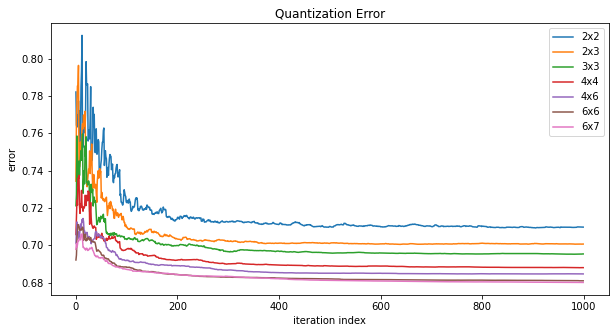

In [26]:
max_iter = 1000
q_error1 = []
q_error2 = []
q_error3 = []
q_error4 = []
q_error5 = []
q_error6 = []
q_error7 = []

fig = plt.figure(figsize= (10,5))

for i in range(max_iter):
    rand_i = np.random.randint(len(x))
    som1.update(x[rand_i], som1.winner(x[rand_i]), i)
    q_error1.append(som1.quantization_error(x))
    
    rand_i = np.random.randint(len(x))
    som2.update(x[rand_i], som2.winner(x[rand_i]), i)
    q_error2.append(som2.quantization_error(x))
    
    rand_i = np.random.randint(len(x))
    som3.update(x[rand_i], som3.winner(x[rand_i]), i)
    q_error3.append(som3.quantization_error(x))
    
    rand_i = np.random.randint(len(x))
    som4.update(x[rand_i], som4.winner(x[rand_i]), i)
    q_error4.append(som4.quantization_error(x))
    
    rand_i = np.random.randint(len(x))
    som5.update(x[rand_i], som5.winner(x[rand_i]), i)
    q_error5.append(som5.quantization_error(x))
    
    rand_i = np.random.randint(len(x))
    som6.update(x[rand_i], som6.winner(x[rand_i]), i)
    q_error6.append(som6.quantization_error(x))
    
    rand_i = np.random.randint(len(x))
    som7.update(x[rand_i], som7.winner(x[rand_i]), i)
    q_error7.append(som7.quantization_error(x))

plt.title("Quantization Error")
plt.plot(np.arange(max_iter), q_error1, label='2x2')
plt.plot(np.arange(max_iter), q_error2, label='2x3')
plt.plot(np.arange(max_iter), q_error3, label='3x3')
plt.plot(np.arange(max_iter), q_error4, label='4x4')
plt.plot(np.arange(max_iter), q_error5, label='4x6')
plt.plot(np.arange(max_iter), q_error6, label='6x6')
plt.plot(np.arange(max_iter), q_error7, label='6x7')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()

plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_107/quantization_error.png", dpi=300)
plt.show()

In [27]:
som = som4

(349,)


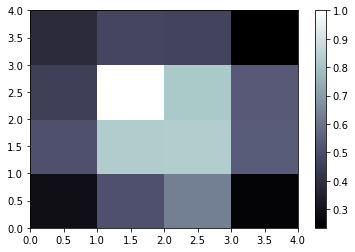

In [28]:
from pylab import bone,pcolor,colorbar,plot,show
bone()
pcolor(som.distance_map().T)
colorbar()

# make an array for the groupings
groupings = np.empty((0,2))
for i,a in enumerate(x):
    w = som.winner(a)
    groupings = np.append(groupings,np.array([w]),axis=0)
#print(groupings)

# remake the groupings into numbers
gr_idx = np.array([])
for l in groupings:
    if l[0] == 0:
        if l[1] == 0:
            gr_idx = np.append(gr_idx,0)
        if l[1] == 1:
            gr_idx = np.append(gr_idx,1)
        if l[1] == 2:
            gr_idx = np.append(gr_idx,2)
        if l[1] == 3:
            gr_idx = np.append(gr_idx,3)
    elif l[0] == 1:
        if l[1] == 0:
            gr_idx = np.append(gr_idx,4)
        if l[1] == 1:
            gr_idx = np.append(gr_idx,5)
        if l[1] == 2:
            gr_idx = np.append(gr_idx,6)
        if l[1] == 3:
            gr_idx = np.append(gr_idx,7)
    elif l[0] == 2:
        if l[1] == 0:
            gr_idx = np.append(gr_idx,8)
        if l[1] == 1:
            gr_idx = np.append(gr_idx,9)
        if l[1] == 2:
            gr_idx = np.append(gr_idx,10)
        if l[1] == 3:
            gr_idx = np.append(gr_idx,11)
    elif l[0] == 3:
        if l[1] == 0:
            gr_idx = np.append(gr_idx,12)
        if l[1] == 1:
            gr_idx = np.append(gr_idx,13)
        if l[1] == 2:
            gr_idx = np.append(gr_idx,14)
        if l[1] == 3:
            gr_idx = np.append(gr_idx,15)
print(gr_idx.shape)

## Create a TS diagram colored based on the categories

In [29]:
aabw_cmap = np.tile(gr_idx,(65717,1))
aabw_cmap.shape
aabw_cmap

array([[ 5.,  2., 15., ...,  5.,  8.,  9.],
       [ 5.,  2., 15., ...,  5.,  8.,  9.],
       [ 5.,  2., 15., ...,  5.,  8.,  9.],
       ...,
       [ 5.,  2., 15., ...,  5.,  8.,  9.],
       [ 5.,  2., 15., ...,  5.,  8.,  9.],
       [ 5.,  2., 15., ...,  5.,  8.,  9.]])

In [30]:
set(gr_idx)

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0}

In [31]:
# break down the aabw_salt and aabw_temp by the indices of the groups
group0 = np.where(gr_idx == 0)
group1 = np.where(gr_idx == 1)
group2 = np.where(gr_idx == 2)
group3 = np.where(gr_idx == 3)
group4 = np.where(gr_idx == 4)
group5 = np.where(gr_idx == 5)
group6 = np.where(gr_idx == 6)
group7 = np.where(gr_idx == 7)
group8 = np.where(gr_idx == 8)
group9 = np.where(gr_idx == 9)
group10 = np.where(gr_idx == 10)
group11 = np.where(gr_idx == 11)
group12 = np.where(gr_idx == 12)
group13 = np.where(gr_idx == 13)
group14 = np.where(gr_idx == 14)
group15 = np.where(gr_idx == 15)

# group hte aabw_salt and aabw_temp by these indices
aabw_salt0 = aabw_salt[:,group0]
aabw_salt1 = aabw_salt[:,group1]
aabw_salt2 = aabw_salt[:,group2]
aabw_salt3 = aabw_salt[:,group3]
aabw_salt4 = aabw_salt[:,group4]
aabw_salt5 = aabw_salt[:,group5]
aabw_salt6 = aabw_salt[:,group6]
aabw_salt7 = aabw_salt[:,group7]
aabw_salt8 = aabw_salt[:,group8]
aabw_salt9 = aabw_salt[:,group9]
aabw_salt10 = aabw_salt[:,group10]
aabw_salt11 = aabw_salt[:,group11]
aabw_salt12 = aabw_salt[:,group12]
aabw_salt13 = aabw_salt[:,group13]
aabw_salt14 = aabw_salt[:,group14]
aabw_salt15 = aabw_salt[:,group15]

aabw_temp0 = aabw_temp[:,group0]
aabw_temp1 = aabw_temp[:,group1]
aabw_temp2 = aabw_temp[:,group2]
aabw_temp3 = aabw_temp[:,group3]
aabw_temp4 = aabw_temp[:,group4]
aabw_temp5 = aabw_temp[:,group5]
aabw_temp6 = aabw_temp[:,group6]
aabw_temp7 = aabw_temp[:,group7]
aabw_temp8 = aabw_temp[:,group8]
aabw_temp9 = aabw_temp[:,group9]
aabw_temp10 = aabw_temp[:,group10]
aabw_temp11 = aabw_temp[:,group11]
aabw_temp12 = aabw_temp[:,group12]
aabw_temp13 = aabw_temp[:,group13]
aabw_temp14 = aabw_temp[:,group14]
aabw_temp15 = aabw_temp[:,group15]

### Find average pathways based on the categorizations in the color index

In [32]:
#gr_idx.shape
group0 = np.where(gr_idx == 0)[0]
group1 = np.where(gr_idx == 1)[0]
group2 = np.where(gr_idx == 2)[0]
group3 = np.where(gr_idx == 3)[0]
group4 = np.where(gr_idx == 4)[0]
group5 = np.where(gr_idx == 5)[0]
group6 = np.where(gr_idx == 6)[0]
group7 = np.where(gr_idx == 7)[0]
group8 = np.where(gr_idx == 8)[0]
group9 = np.where(gr_idx == 9)[0]
group10 = np.where(gr_idx == 10)[0]
group11 = np.where(gr_idx == 11)[0]
group12 = np.where(gr_idx == 12)[0]
group13 = np.where(gr_idx == 13)[0]
group14 = np.where(gr_idx == 14)[0]
group15 = np.where(gr_idx == 15)[0]

group0n = np.array([],dtype=int)
for i in group0:
    group0n = np.append(group0n,int(aabw_idx[i]))
group1n = np.array([],dtype=int)
for i in group1:
    group1n = np.append(group1n,int(aabw_idx[i]))
group2n = np.array([],dtype=int)
for i in group2:
    group2n = np.append(group2n,int(aabw_idx[i]))
group3n = np.array([],dtype=int)
for i in group3:
    group3n = np.append(group3n,int(aabw_idx[i]))
group4n = np.array([],dtype=int)
for i in group4:
    group4n = np.append(group4n,int(aabw_idx[i]))
group5n = np.array([],dtype=int)
for i in group5:
    group5n = np.append(group5n,int(aabw_idx[i]))
group6n = np.array([],dtype=int)
for i in group6:
    group6n = np.append(group6n,int(aabw_idx[i]))
group7n = np.array([],dtype=int)
for i in group7:
    group7n = np.append(group7n,int(aabw_idx[i]))
group8n = np.array([],dtype=int)
for i in group8:
    group8n = np.append(group8n,int(aabw_idx[i]))
group9n = np.array([],dtype=int)
for i in group9:
    group9n = np.append(group9n,int(aabw_idx[i]))
group10n = np.array([],dtype=int)
for i in group10:
    group10n = np.append(group10n,int(aabw_idx[i]))
group11n = np.array([],dtype=int)
for i in group11:
    group11n = np.append(group11n,int(aabw_idx[i]))
group12n = np.array([],dtype=int)
for i in group12:
    group12n = np.append(group12n,int(aabw_idx[i]))
group13n = np.array([],dtype=int)
for i in group13:
    group13n = np.append(group13n,int(aabw_idx[i]))
group14n = np.array([],dtype=int)
for i in group14:
    group14n = np.append(group14n,int(aabw_idx[i]))
group15n = np.array([],dtype=int)
for i in group15:
    group15n = np.append(group15n,int(aabw_idx[i]))

In [33]:
# find the average location pathway for each group
group0x = ds.variables['Xgrid'][:,group0n]
group1x = ds.variables['Xgrid'][:,group1n]
group2x = ds.variables['Xgrid'][:,group2n]
group3x = ds.variables['Xgrid'][:,group3n]
group4x = ds.variables['Xgrid'][:,group4n]
group5x = ds.variables['Xgrid'][:,group5n]
group6x = ds.variables['Xgrid'][:,group6n]
group7x = ds.variables['Xgrid'][:,group7n]
group8x = ds.variables['Xgrid'][:,group8n]
group9x = ds.variables['Xgrid'][:,group9n]
group10x = ds.variables['Xgrid'][:,group10n]
group11x = ds.variables['Xgrid'][:,group11n]
group12x = ds.variables['Xgrid'][:,group12n]
group13x = ds.variables['Xgrid'][:,group13n]
group14x = ds.variables['Xgrid'][:,group14n]
group15x = ds.variables['Xgrid'][:,group15n]

group0y = ds.variables['Ygrid'][:,group0n]
group1y = ds.variables['Ygrid'][:,group1n]
group2y = ds.variables['Ygrid'][:,group2n]
group3y = ds.variables['Ygrid'][:,group3n]
group4y = ds.variables['Ygrid'][:,group4n]
group5y = ds.variables['Ygrid'][:,group5n]
group6y = ds.variables['Ygrid'][:,group6n]
group7y = ds.variables['Ygrid'][:,group7n]
group8y = ds.variables['Ygrid'][:,group8n]
group9y = ds.variables['Ygrid'][:,group9n]
group10y = ds.variables['Ygrid'][:,group10n]
group11y = ds.variables['Ygrid'][:,group11n]
group12y = ds.variables['Ygrid'][:,group12n]
group13y = ds.variables['Ygrid'][:,group13n]
group14y = ds.variables['Ygrid'][:,group14n]
group15y = ds.variables['Ygrid'][:,group15n]

In [34]:
# find the average of these and make into lat/long values
g0x_avg = np.nanmean(group0x,axis=1)
g1x_avg = np.nanmean(group1x,axis=1)
g2x_avg = np.nanmean(group2x,axis=1)
g3x_avg = np.nanmean(group3x,axis=1)
g4x_avg = np.nanmean(group4x,axis=1)
g5x_avg = np.nanmean(group5x,axis=1)
g6x_avg = np.nanmean(group6x,axis=1)
g7x_avg = np.nanmean(group7x,axis=1)
g8x_avg = np.nanmean(group8x,axis=1)
g9x_avg = np.nanmean(group9x,axis=1)
g10x_avg = np.nanmean(group10x,axis=1)
g11x_avg = np.nanmean(group11x,axis=1)

g0y_avg = np.nanmean(group0y,axis=1)
g1y_avg = np.nanmean(group1y,axis=1)
g2y_avg = np.nanmean(group2y,axis=1)
g3y_avg = np.nanmean(group3y,axis=1)
g4y_avg = np.nanmean(group4y,axis=1)
g5y_avg = np.nanmean(group5y,axis=1)
g6y_avg = np.nanmean(group6y,axis=1)
g7y_avg = np.nanmean(group7y,axis=1)
g8y_avg = np.nanmean(group8y,axis=1)
g9y_avg = np.nanmean(group9y,axis=1)
g10y_avg = np.nanmean(group10y,axis=1)
g11y_avg = np.nanmean(group11y,axis=1)

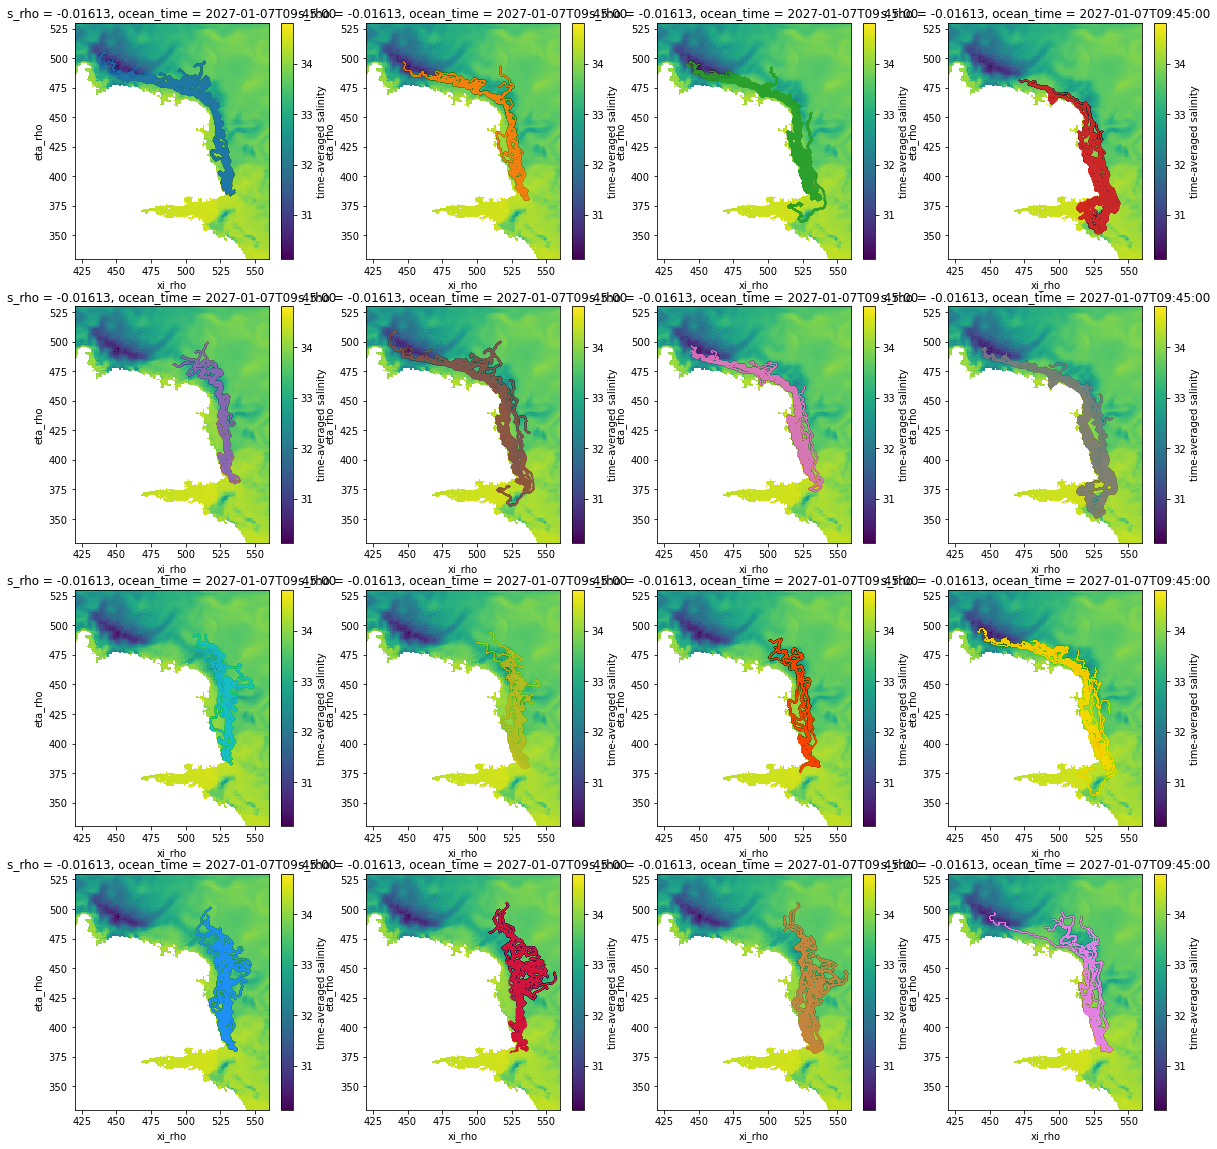

In [35]:
# THESE ARE IN GRID POINTS not spherical
fig = plt.figure(figsize=(20,20))
fig.tight_layout(pad=10)
ax = fig.add_subplot(4, 4, 1)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group0x,group0y,marker='.',s=0.1,color='tab:blue',alpha=0.2)

ax = fig.add_subplot(4, 4, 2)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group1x,group1y,marker='.',s=0.1,color='tab:orange',alpha=0.2)

ax = fig.add_subplot(4, 4, 3)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group2x,group2y,marker='.',s=0.1,color='tab:green',alpha=0.2)

ax = fig.add_subplot(4, 4, 4)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group3x,group3y,marker='.',s=0.1,color='tab:red',alpha=0.2)

ax = fig.add_subplot(4, 4, 5)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group4x,group4y,marker='.',s=0.1,color='tab:purple',alpha=0.2)

ax = fig.add_subplot(4, 4, 6)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group5x,group5y,marker='.',s=0.1,color='tab:brown',alpha=0.2)

ax = fig.add_subplot(4, 4, 7)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group6x,group6y,marker='.',s=0.1,color='tab:pink',alpha=0.2)

ax = fig.add_subplot(4, 4, 8)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group7x,group7y,marker='.',s=0.1,color='tab:gray',alpha=0.2)

ax = fig.add_subplot(4, 4, 9)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group8x,group8y,marker='.',s=0.1,color='tab:cyan',alpha=0.2)

ax = fig.add_subplot(4, 4, 10)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group9x,group9y,marker='.',s=0.1,color='tab:olive',alpha=0.2)

ax = fig.add_subplot(4, 4, 11)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group10x,group10y,marker='.',s=0.1,color='orangered',alpha=0.2)

ax = fig.add_subplot(4, 4, 12)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group11x,group11y,marker='.',s=0.1,color='gold',alpha=0.2)

ax = fig.add_subplot(4, 4, 13)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group12x,group12y,marker='.',s=0.1,color='dodgerblue',alpha=0.2)

ax = fig.add_subplot(4, 4, 14)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group13x,group13y,marker='.',s=0.1,color='crimson',alpha=0.2)

ax = fig.add_subplot(4, 4, 15)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group14x,group14y,marker='.',s=0.1,color='peru',alpha=0.2)

ax = fig.add_subplot(4, 4, 16)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.scatter(group15x,group15y,marker='.',s=0.1,color='violet',alpha=0.2)

plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_107/4by4_mapped_aabw.png", dpi=300)

### See histogram distribution of variables in different nodes

In [36]:
# first see the numbers of floats in each group
df1 = pd.DataFrame()
nmpts = np.array([])
nmpts = np.append(nmpts,len(group0))
nmpts = np.append(nmpts,len(group1))
nmpts = np.append(nmpts,len(group2))
nmpts = np.append(nmpts,len(group3))
nmpts = np.append(nmpts,len(group4))
nmpts = np.append(nmpts,len(group5))
nmpts = np.append(nmpts,len(group6))
nmpts = np.append(nmpts,len(group7))
nmpts = np.append(nmpts,len(group8))
nmpts = np.append(nmpts,len(group9))
nmpts = np.append(nmpts,len(group10))
nmpts = np.append(nmpts,len(group11))
nmpts = np.append(nmpts,len(group12))
nmpts = np.append(nmpts,len(group13))
nmpts = np.append(nmpts,len(group14))
nmpts = np.append(nmpts,len(group15))

# add this to the dataframe
df1["# of points"] = nmpts
df1

,# of points
0,23.0
1,16.0
2,29.0
3,29.0
4,17.0
5,26.0
6,30.0
7,29.0
8,15.0
9,18.0


### Is there a certain month where one group was mostly released?

In [37]:
# print the counts of the months in each group
allgroups = np.array([group0,group1,group2,group3,group4,group5,group6,group7,group8,group9,group10,group11,group12,group13,group14,group15])
for group in allgroups:
    values,counts = np.unique(df_months[group],return_counts = True)
    for i,j in zip(values,counts):
        print(i,j)
    print()

Aug 5
Jul 2
Jun 3
May 3
Oct 2
Sep 8

Apr 4
Aug 3
Jul 1
Jun 1
Oct 2
Sep 5

Apr 4
Jul 6
Jun 3
May 2
Nov 4
Oct 5
Sep 5

Apr 1
Aug 4
Jul 3
Jun 2
Oct 9
Sep 10

Apr 2
Aug 5
Jul 4
Jun 2
May 2
Sep 2

Apr 6
Aug 4
Jul 3
Jun 3
May 7
Nov 1
Oct 1
Sep 1

Aug 7
Jul 7
May 3
Oct 5
Sep 8

Apr 5
Aug 6
Jul 3
Jun 3
May 4
Nov 1
Oct 2
Sep 5

Aug 5
Jul 7
Jun 2
Oct 1

Apr 2
Aug 3
Jul 4
Jun 2
Oct 4
Sep 3

Apr 1
Jul 1
Jun 3
Nov 2
Oct 2

Apr 3
Aug 2
Jul 6
Jun 3
May 3
Nov 3
Oct 1
Sep 2

Apr 2
Aug 3
Jul 6
Jun 6
May 2
Sep 2

Apr 3
Aug 2
Jul 7
Jun 8
May 1
Oct 1
Sep 3

Apr 9
Aug 4
Jul 3
Jun 4
May 3
Sep 1

Apr 2
Aug 2
Jul 1
Jun 2
May 4
Nov 1
Oct 2
Sep 1



In [38]:
# make array of the groups
groups = np.array([group0,group1,group2,group3,group4,group5,group6,group7,group8,group9,group10,group11,group12,group13,group14,group15])

# add mean and stdev of group variables to dataframe
dist_ratio_mean = np.array([])
dist_ratio_stdev = np.array([])
mean_d_mean = np.array([])
mean_d_stdev = np.array([])
std_depth_mean = np.array([])
delta_salt_mean = np.array([])
delta_salt_stdev = np.array([])
delta_density_mean = np.array([])
delta_density_stdev = np.array([])
month_mean = np.array([])
month_std = np.array([])

for group in groups:
    dist_ratio_mean = np.append(dist_ratio_mean,np.mean(df["net distance:total distance"][group].values))
    dist_ratio_stdev = np.append(dist_ratio_stdev,np.std(df["net distance:total distance"][group].values))
    mean_d_mean = np.append(mean_d_mean,np.mean(df["mean depth"][group].values))
    mean_d_stdev = np.append(mean_d_stdev,np.std(df["mean depth"][group].values))
    std_depth_mean = np.append(std_depth_mean,np.mean(df["std depth"][group].values))
    delta_salt_mean = np.append(delta_salt_mean,np.mean(df["d salt"][group].values))
    delta_salt_stdev = np.append(delta_salt_stdev,np.std(df["d salt"][group].values))
    delta_density_mean = np.append(delta_density_mean,np.mean(df["d density"][group].values))
    delta_density_stdev = np.append(delta_density_stdev,np.std(df["d density"][group].values))
    month_mean = np.append(month_mean,np.mean(df_months_i[group]))
    month_std = np.append(month_std,np.std(df_months_i[group]))

In [39]:
df1["Distance ratio mean"] = dist_ratio_mean
df1["Distance ratio stdev"] = dist_ratio_stdev
df1["Mean depth mean"] = mean_d_mean
df1["Mean depth stdev"] = mean_d_stdev
df1["stdev depth"] = std_depth_mean
df1["delta salt mean"] = delta_salt_mean
df1["delta salt stdev"] = delta_salt_stdev
df1["delta density mean"] = delta_density_mean
df1["delta density stdev"] = delta_density_stdev
df1["average month"] = month_mean
df1["stdev month"] = month_std
df1

,# of points,Distance ratio mean,Distance ratio stdev,Mean depth mean,Mean depth stdev,stdev depth,delta salt mean,delta salt stdev,delta density mean,delta density stdev,average month,stdev month
0,23.0,0.231476,0.042933,-1579.577677,326.856172,674.903361,0.011183,0.032990,-0.218500,0.000000,7.782609,1.559167
1,16.0,0.230727,0.021776,-1712.046294,323.820898,742.539295,0.070604,0.028543,-0.218500,0.000000,7.375000,2.175862
2,29.0,0.183279,0.029858,-1047.172242,129.011532,733.347381,0.068207,0.030595,-0.218500,0.000000,7.758621,2.343813
3,29.0,0.180685,0.050694,-531.449381,180.735375,415.014997,0.064153,0.034957,-0.218500,0.000000,8.586207,1.474314
4,17.0,0.307253,0.046560,-2467.825254,352.046577,1104.174331,0.035313,0.023382,-0.218500,0.000000,6.823529,1.542927
5,26.0,0.221768,0.048444,-1384.982612,228.109846,1092.826853,0.031761,0.026515,-0.218500,0.000000,6.153846,1.955118
6,30.0,0.202766,0.037150,-963.783843,213.305359,816.281989,-0.026514,0.037981,-0.218500,0.000000,8.066667,1.436044
7,29.0,0.177777,0.034678,-795.552621,158.531358,788.778394,0.063773,0.038011,-0.218500,0.000000,7.000000,2.067816
8,15.0,0.370727,0.034031,-2916.709582,465.947305,1216.642061,-0.046201,0.032588,-0.218500,0.000000,7.400000,0.952190
9,18.0,0.328208,0.040048,-2389.114948,278.563740,1534.474087,0.052492,0.017957,-0.227329,0.036403,7.722222,1.850092


In [71]:
df

,net distance:total distance,mean depth,std depth,dT,d salt,d density,time to aabw,Month Released
0,0.232526,-1380.633472,1121.455566,1.680688,0.094780,-0.218500,251.385417,4.0
1,0.152179,-1336.957750,931.876587,1.542820,0.098309,-0.218500,178.812500,5.0
2,0.256917,-2007.275123,1611.854492,1.443755,0.091187,-0.218500,225.406250,6.0
3,0.237887,-2704.539751,1336.700073,1.534747,0.080845,-0.218500,81.250000,9.0
4,0.311488,-3432.437147,1241.449463,1.585744,0.135159,-0.218500,53.812500,4.0
...,...,...,...,...,...,...,...,...
344,0.265898,-2362.878106,1699.251465,1.580574,0.018871,-0.218500,162.885417,7.0
345,0.341715,-2707.108203,995.262634,1.643226,-0.040470,-0.218500,51.343750,7.0
346,0.211158,-1401.438010,1208.631592,1.611109,0.055897,-0.218500,214.197917,8.0
347,0.379855,-2535.859073,1578.445312,1.546849,-0.042156,-0.218500,137.197917,8.0


## Plot the distributions

In [40]:
df["Month Released"] = df_months_i

In [41]:
df

,net distance:total distance,mean depth,std depth,dT,d salt,d density,time to aabw,Month Released
0,0.232526,-1380.633472,1121.455566,1.680688,0.094780,-0.218500,251.385417,4.0
1,0.152179,-1336.957750,931.876587,1.542820,0.098309,-0.218500,178.812500,5.0
2,0.256917,-2007.275123,1611.854492,1.443755,0.091187,-0.218500,225.406250,6.0
3,0.237887,-2704.539751,1336.700073,1.534747,0.080845,-0.218500,81.250000,9.0
4,0.311488,-3432.437147,1241.449463,1.585744,0.135159,-0.218500,53.812500,4.0
...,...,...,...,...,...,...,...,...
344,0.265898,-2362.878106,1699.251465,1.580574,0.018871,-0.218500,162.885417,7.0
345,0.341715,-2707.108203,995.262634,1.643226,-0.040470,-0.218500,51.343750,7.0
346,0.211158,-1401.438010,1208.631592,1.611109,0.055897,-0.218500,214.197917,8.0
347,0.379855,-2535.859073,1578.445312,1.546849,-0.042156,-0.218500,137.197917,8.0


In [42]:
print(df.columns.shape)
print(df.columns[7])

(8,)
Month Released


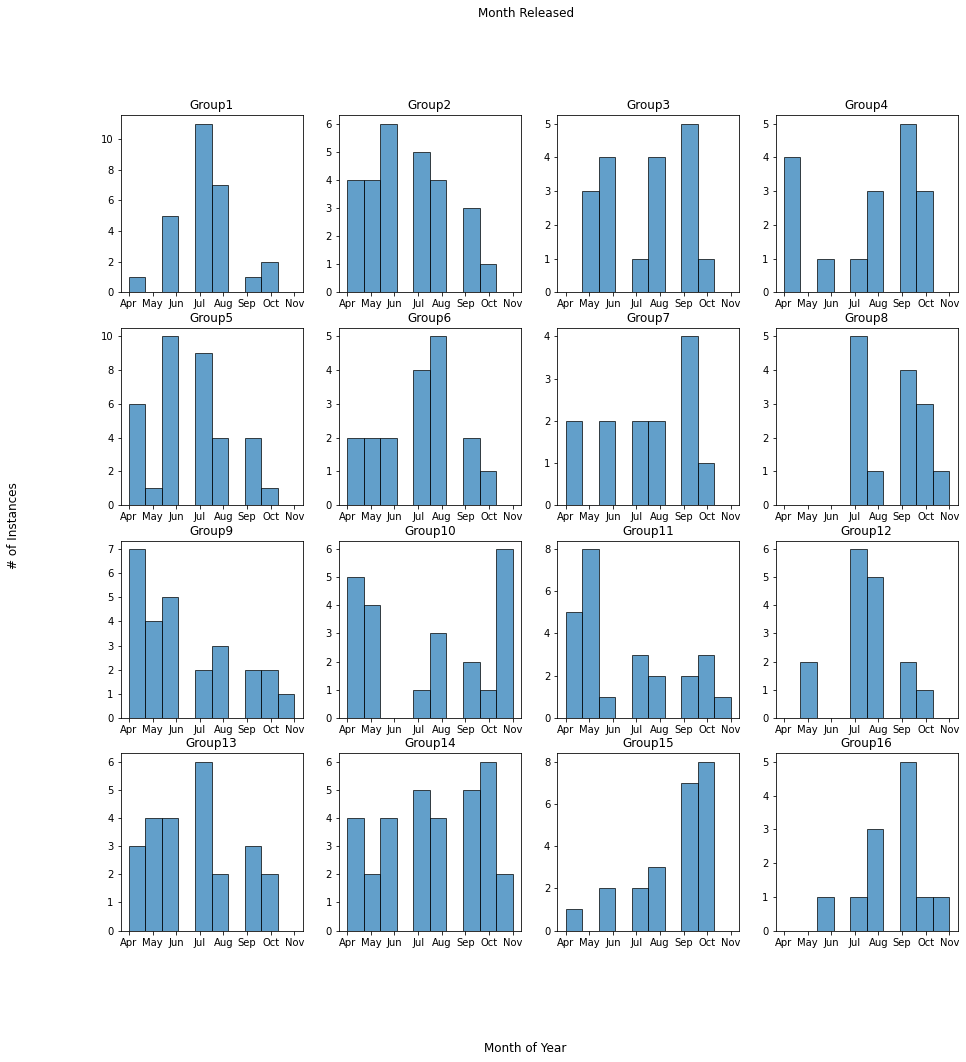

In [53]:
# Distribution of Various Quantities
fig = plt.figure(figsize = (15,15))
plt.suptitle("Month Released")
fig.supxlabel('Month of Year')
fig.supylabel('# of Instances')
i = 1

thisfig = df.columns[7]
for group in groups:
    ax = fig.add_subplot(4, 4, i)
    ax.hist(df[thisfig][group].values,alpha=0.7,edgecolor="black",range=[4,11])
    mystr = "Group" + str(i)
    plt.xticks(ticks=[4,5,6,7,8,9,10,11],labels=["Apr","May","Jun","Jul","Aug","Sep","Oct","Nov"])
    plt.title(mystr)
    i  += 1
    
plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_107/month_distributions.png", dpi=300)

### Create the groups of temperature plots colored by depth

In [43]:
# get the first depths and times at which particles are released
depth = ds.variables['depth'].values[:,aabw_idx]
temp = ds.variables['temp'].values[:,aabw_idx]

time = temp.shape[0]
time = np.arange(0,time,1)
x_time = np.tile(time,(349,1))
x_time = x_time.T   # this will be our time matrix to color the numbers
x_time = x_time*900/86400

# mark the first values in each column
first_depths = np.array([])
first_times = np.array([])
a = depth[:,0]
b = a[~np.isnan(a)]

for idx in (range(depth.shape[1])):
    a = depth[:,idx]
    b = a[~np.isnan(a)]
    first_depths = np.append(first_depths,b[0])
    first_times = np.append(first_times,(len(a)-len(b))*900/86400)

In [44]:
# separate the depth values by group
depth0 = ds.variables["depth"].values[:,group0n]
depth1 = ds.variables["depth"].values[:,group1n]
depth2 = ds.variables["depth"].values[:,group2n]
depth3 = ds.variables["depth"].values[:,group3n]
depth4 = ds.variables["depth"].values[:,group4n]
depth5 = ds.variables["depth"].values[:,group5n]
depth6 = ds.variables["depth"].values[:,group6n]
depth7 = ds.variables["depth"].values[:,group7n]
depth8 = ds.variables["depth"].values[:,group8n]
depth9 = ds.variables["depth"].values[:,group9n]
depth10 = ds.variables["depth"].values[:,group10n]
depth11 = ds.variables["depth"].values[:,group11n]
depth12 = ds.variables["depth"].values[:,group12n]
depth13 = ds.variables["depth"].values[:,group13n]
depth14 = ds.variables["depth"].values[:,group14n]
depth15 = ds.variables["depth"].values[:,group15n]

# temperature arrays
temp0 = ds.variables['temp'].values[:,group0n]
temp1 = ds.variables['temp'].values[:,group1n]
temp2 = ds.variables['temp'].values[:,group2n]
temp3 = ds.variables['temp'].values[:,group3n]
temp4 = ds.variables['temp'].values[:,group4n]
temp5 = ds.variables['temp'].values[:,group5n]
temp6 = ds.variables['temp'].values[:,group6n]
temp7 = ds.variables['temp'].values[:,group7n]
temp8 = ds.variables['temp'].values[:,group8n]
temp9 = ds.variables['temp'].values[:,group9n]
temp10 = ds.variables['temp'].values[:,group10n]
temp11 = ds.variables['temp'].values[:,group11n]
temp12 = ds.variables['temp'].values[:,group12n]
temp13 = ds.variables['temp'].values[:,group13n]
temp14 = ds.variables['temp'].values[:,group14n]
temp15 = ds.variables['temp'].values[:,group15n]

### Reset the the arrays to <-500m

In [45]:
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth0_500 = np.empty((0,65717))
temp0_500 = np.empty((0,65717))
for idx in range(len(depth0[0])):
    # find each point that is below 500m
    thisdepth = depth0[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp0[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth0_500 = np.append(depth0_500,np.array([thisdepth]),axis=0)
    temp0_500 = np.append(temp0_500,np.array([thistemp]),axis=0)

In [46]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth1_500 = np.empty((0,65717))
temp1_500 = np.empty((0,65717))
for idx in range(len(depth1[0])):
    # find each point that is below 500m
    thisdepth = depth1[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp1[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth1_500 = np.append(depth1_500,np.array([thisdepth]),axis=0)
    temp1_500 = np.append(temp1_500,np.array([thistemp]),axis=0)

In [47]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth2_500 = np.empty((0,65717))
temp2_500 = np.empty((0,65717))
for idx in range(len(depth2[0])):
    # find each point that is below 500m
    thisdepth = depth2[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp2[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth2_500 = np.append(depth2_500,np.array([thisdepth]),axis=0)
    temp2_500 = np.append(temp2_500,np.array([thistemp]),axis=0)

In [48]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth3_500 = np.empty((0,65717))
temp3_500 = np.empty((0,65717))
for idx in range(len(depth3[0])):
    # find each point that is below 500m
    thisdepth = depth3[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp3[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth3_500 = np.append(depth3_500,np.array([thisdepth]),axis=0)
    temp3_500 = np.append(temp3_500,np.array([thistemp]),axis=0)

In [49]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth4_500 = np.empty((0,65717))
temp4_500 = np.empty((0,65717))
for idx in range(len(depth4[0])):
    # find each point that is below 500m
    thisdepth = depth4[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp4[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth4_500 = np.append(depth4_500,np.array([thisdepth]),axis=0)
    temp4_500 = np.append(temp4_500,np.array([thistemp]),axis=0)

In [50]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth5_500 = np.empty((0,65717))
temp5_500 = np.empty((0,65717))
for idx in range(len(depth5[0])):
    # find each point that is below 500m
    thisdepth = depth5[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp5[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth5_500 = np.append(depth5_500,np.array([thisdepth]),axis=0)
    temp5_500 = np.append(temp5_500,np.array([thistemp]),axis=0)

In [51]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth6_500 = np.empty((0,65717))
temp6_500 = np.empty((0,65717))
for idx in range(len(depth6[0])):
    # find each point that is below 500m
    thisdepth = depth6[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp6[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth6_500 = np.append(depth6_500,np.array([thisdepth]),axis=0)
    temp6_500 = np.append(temp6_500,np.array([thistemp]),axis=0)

In [52]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth7_500 = np.empty((0,65717))
temp7_500 = np.empty((0,65717))
for idx in range(len(depth7[0])):
    # find each point that is below 500m
    thisdepth = depth7[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp7[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth7_500 = np.append(depth7_500,np.array([thisdepth]),axis=0)
    temp7_500 = np.append(temp7_500,np.array([thistemp]),axis=0)

In [53]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth8_500 = np.empty((0,65717))
temp8_500 = np.empty((0,65717))
for idx in range(len(depth8[0])):
    # find each point that is below 500m
    thisdepth = depth8[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp8[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth8_500 = np.append(depth8_500,np.array([thisdepth]),axis=0)
    temp8_500 = np.append(temp8_500,np.array([thistemp]),axis=0)

In [54]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth9_500 = np.empty((0,65717))
temp9_500 = np.empty((0,65717))
for idx in range(len(depth9[0])):
    # find each point that is below 500m
    thisdepth = depth9[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp9[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth9_500 = np.append(depth9_500,np.array([thisdepth]),axis=0)
    temp9_500 = np.append(temp9_500,np.array([thistemp]),axis=0)

In [55]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth10_500 = np.empty((0,65717))
temp10_500 = np.empty((0,65717))
for idx in range(len(depth10[0])):
    # find each point that is below 500m
    thisdepth = depth10[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp10[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth10_500 = np.append(depth10_500,np.array([thisdepth]),axis=0)
    temp10_500 = np.append(temp10_500,np.array([thistemp]),axis=0)

In [56]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth11_500 = np.empty((0,65717))
temp11_500 = np.empty((0,65717))
for idx in range(len(depth11[0])):
    # find each point that is below 500m
    thisdepth = depth11[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp11[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth11_500 = np.append(depth11_500,np.array([thisdepth]),axis=0)
    temp11_500 = np.append(temp11_500,np.array([thistemp]),axis=0)

In [57]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth12_500 = np.empty((0,65717))
temp12_500 = np.empty((0,65717))
for idx in range(len(depth12[0])):
    # find each point that is below 500m
    thisdepth = depth12[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp12[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth12_500 = np.append(depth12_500,np.array([thisdepth]),axis=0)
    temp12_500 = np.append(temp12_500,np.array([thistemp]),axis=0)

In [58]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth13_500 = np.empty((0,65717))
temp13_500 = np.empty((0,65717))
for idx in range(len(depth13[0])):
    # find each point that is below 500m
    thisdepth = depth13[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp13[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth13_500 = np.append(depth13_500,np.array([thisdepth]),axis=0)
    temp13_500 = np.append(temp13_500,np.array([thistemp]),axis=0)

In [59]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth14_500 = np.empty((0,65717))
temp14_500 = np.empty((0,65717))
for idx in range(len(depth14[0])):
    # find each point that is below 500m
    thisdepth = depth14[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp14[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth14_500 = np.append(depth14_500,np.array([thisdepth]),axis=0)
    temp14_500 = np.append(temp14_500,np.array([thistemp]),axis=0)

In [60]:
# set the second group
# for each row, get the index at which it crosses <=-500 m, then fill the rest with nan
depth15_500 = np.empty((0,65717))
temp15_500 = np.empty((0,65717))
for idx in range(len(depth15[0])):
    # find each point that is below 500m
    thisdepth = depth15[:,idx].tolist()
    firstdepthidx = next(x for x, val in enumerate(thisdepth) if val <= -500)
    thisdepth = thisdepth[firstdepthidx:]
    thisdepth = np.asarray(thisdepth)
    
    # create the temperature arrays
    thistemp = temp15[:,idx].tolist()
    thistemp = thistemp[firstdepthidx:]
    thistemp = np.asarray(thistemp)
    
    # backfill with nan
    diff = 65717 - len(thisdepth)
    for i in range(diff):
        thisdepth = np.append(thisdepth,np.nan)
        thistemp = np.append(thistemp,np.nan)
        
    # append the row to the depth array
    depth15_500 = np.append(depth15_500,np.array([thisdepth]),axis=0)
    temp15_500 = np.append(temp15_500,np.array([thistemp]),axis=0)

In [61]:
# these are the values starting at -500
depth0 = depth0_500.T
temp0 = temp0_500.T
depth1 = depth1_500.T
temp1 = temp1_500.T
depth2 = depth2_500.T
temp2 = temp2_500.T
depth3 = depth3_500.T
temp3 = temp3_500.T
depth4 = depth4_500.T
temp4 = temp4_500.T
depth5 = depth5_500.T
temp5 = temp5_500.T
depth6 = depth6_500.T
temp6 = temp6_500.T
depth7 = depth7_500.T
temp7 = temp7_500.T
depth8 = depth8_500.T
temp8 = temp8_500.T
depth9 = depth9_500.T
temp9 = temp9_500.T
depth10 = depth10_500.T
temp10 = temp10_500.T
depth11 = depth11_500.T
temp11 = temp11_500.T
depth12 = depth12_500.T
temp12 = temp12_500.T
depth13 = depth13_500.T
temp13 = temp13_500.T
depth14 = depth14_500.T
temp14 = temp14_500.T
depth15 = depth15_500.T
temp15 = temp15_500.T

In [62]:
time = temp.shape[0]
time = np.arange(0,time,1)
x_time0 = np.tile(time,(depth0.shape[1],1))
x_time0 = x_time0.T   # this will be our time matrix to color the numbers
x_time0 = x_time0*900/86400
x_time1 = np.tile(time,(depth1.shape[1],1))
x_time1 = x_time1.T   # this will be our time matrix to color the numbers
x_time1 = x_time1*900/86400
x_time2 = np.tile(time,(depth2.shape[1],1))
x_time2 = x_time2.T   # this will be our time matrix to color the numbers
x_time2 = x_time2*900/86400
x_time3 = np.tile(time,(depth3.shape[1],1))
x_time3 = x_time3.T   # this will be our time matrix to color the numbers
x_time3 = x_time3*900/86400
x_time4 = np.tile(time,(depth4.shape[1],1))
x_time4 = x_time4.T   # this will be our time matrix to color the numbers
x_time4 = x_time4*900/86400
x_time5 = np.tile(time,(depth5.shape[1],1))
x_time5 = x_time5.T   # this will be our time matrix to color the numbers
x_time5 = x_time5*900/86400
x_time6 = np.tile(time,(depth6.shape[1],1))
x_time6 = x_time6.T   # this will be our time matrix to color the numbers
x_time6 = x_time6*900/86400
x_time7 = np.tile(time,(depth7.shape[1],1))
x_time7 = x_time7.T   # this will be our time matrix to color the numbers
x_time7 = x_time7*900/86400
x_time8 = np.tile(time,(depth8.shape[1],1))
x_time8 = x_time8.T   # this will be our time matrix to color the numbers
x_time8 = x_time8*900/86400
x_time9 = np.tile(time,(depth9.shape[1],1))
x_time9 = x_time9.T   # this will be our time matrix to color the numbers
x_time9 = x_time9*900/86400
x_time10 = np.tile(time,(depth10.shape[1],1))
x_time10 = x_time10.T   # this will be our time matrix to color the numbers
x_time10 = x_time10*900/86400
x_time11 = np.tile(time,(depth11.shape[1],1))
x_time11 = x_time11.T   # this will be our time matrix to color the numbers
x_time11 = x_time11*900/86400
x_time12 = np.tile(time,(depth12.shape[1],1))
x_time12 = x_time12.T   # this will be our time matrix to color the numbers
x_time12 = x_time12*900/86400
x_time13 = np.tile(time,(depth13.shape[1],1))
x_time13 = x_time13.T   # this will be our time matrix to color the numbers
x_time13 = x_time13*900/86400
x_time14 = np.tile(time,(depth14.shape[1],1))
x_time14 = x_time14.T   # this will be our time matrix to color the numbers
x_time14 = x_time14*900/86400
x_time15 = np.tile(time,(depth15.shape[1],1))
x_time15 = x_time15.T   # this will be our time matrix to color the numbers
x_time15 = x_time15*900/86400

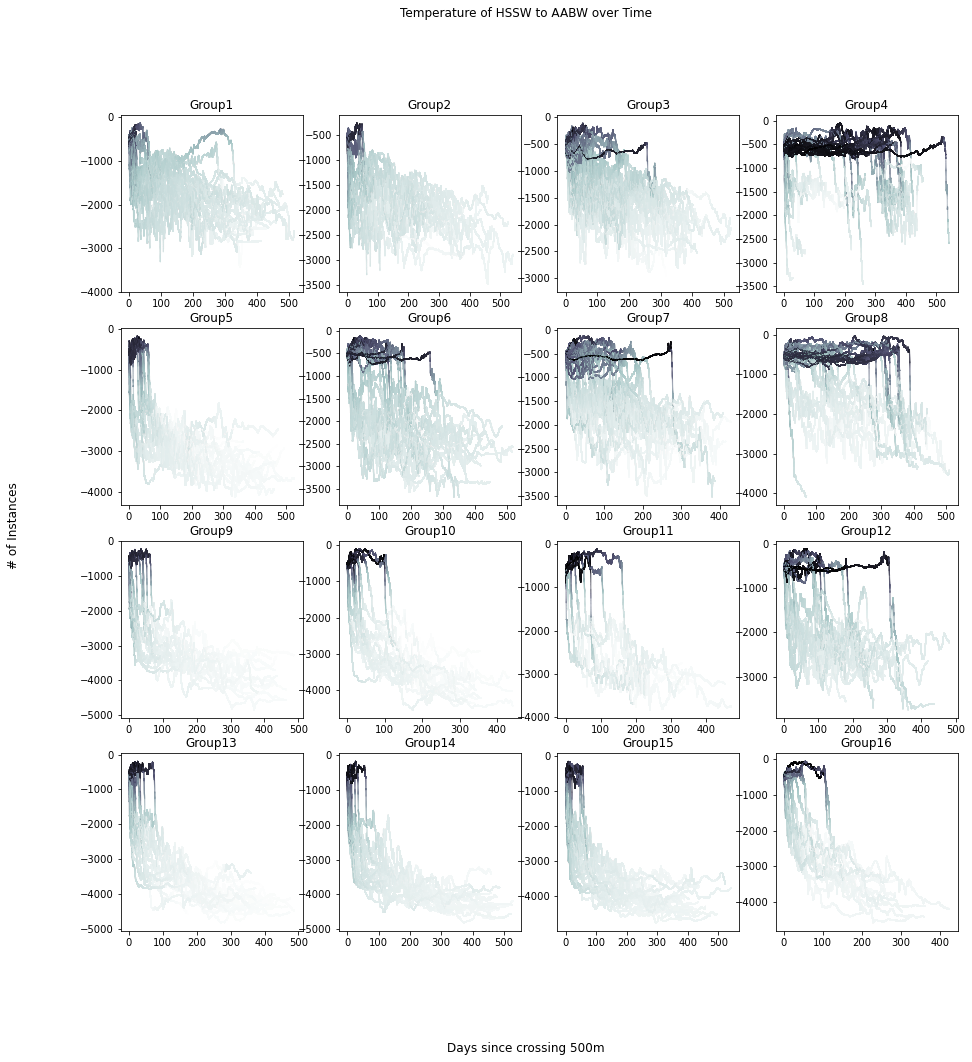

In [63]:
# plot particles with y=depth, x=time, color=temp
fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=5.0)

x_vals = [x_time0,x_time1,x_time2,x_time3,x_time4,x_time5,x_time6,x_time7,x_time8,x_time9,x_time10,x_time11,x_time12,x_time13,x_time14,x_time15]
d_vals = [depth0,depth1,depth2,depth3,depth4,depth5,depth6,depth7,depth8,depth9,depth10,depth11,depth12,depth13,depth14,depth15]
c_vals = [temp0,temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,temp10,temp11,temp12,temp13,temp14,temp15]
i = 1

fig.suptitle("Temperature of HSSW to AABW over Time")
fig.supxlabel('Days since crossing 500m')
fig.supylabel('# of Instances')

for x,d,c in zip(x_vals,d_vals,c_vals):
    ax = fig.add_subplot(4, 4, i)
    plt.scatter(x,d,marker=".",s=0.05,c=c)
    plt.title("Group"+str(i))
    i += 1
plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_107/4x4T_over_time.png", dpi=300)

## Map dTdt over time

In [64]:
dTdt = np.diff(temp0,axis=0)
dTdt0 = dTdt/(900/86400)
x_new0 = x_time0[1:]
depth_new0 = depth0[1:]

dTdt = np.diff(temp1,axis=0)
dTdt1 = dTdt/(900/86400)
x_new1 = x_time1[1:]
depth_new1 = depth1[1:]

dTdt = np.diff(temp2,axis=0)
dTdt2 = dTdt/(900/86400)
x_new2 = x_time2[1:]
depth_new2 = depth2[1:]

dTdt = np.diff(temp3,axis=0)
dTdt3 = dTdt/(900/86400)
x_new3 = x_time3[1:]
depth_new3 = depth3[1:]

dTdt = np.diff(temp4,axis=0)
dTdt4 = dTdt/(900/86400)
x_new4 = x_time4[1:]
depth_new4 = depth4[1:]

dTdt = np.diff(temp5,axis=0)
dTdt5 = dTdt/(900/86400)
x_new5 = x_time5[1:]
depth_new5 = depth5[1:]

dTdt = np.diff(temp6,axis=0)
dTdt6 = dTdt/(900/86400)
x_new6 = x_time6[1:]
depth_new6 = depth6[1:]

dTdt = np.diff(temp7,axis=0)
dTdt7 = dTdt/(900/86400)
x_new7 = x_time7[1:]
depth_new7 = depth7[1:]

dTdt = np.diff(temp8,axis=0)
dTdt8 = dTdt/(900/86400)
x_new8 = x_time8[1:]
depth_new8 = depth8[1:]

dTdt = np.diff(temp9,axis=0)
dTdt9 = dTdt/(900/86400)
x_new9 = x_time9[1:]
depth_new9 = depth9[1:]

dTdt = np.diff(temp10,axis=0)
dTdt10 = dTdt/(900/86400)
x_new10 = x_time10[1:]
depth_new10 = depth10[1:]

dTdt = np.diff(temp11,axis=0)
dTdt11 = dTdt/(900/86400)
x_new11 = x_time11[1:]
depth_new11 = depth11[1:]

dTdt = np.diff(temp12,axis=0)
dTdt12 = dTdt/(900/86400)
x_new12 = x_time12[1:]
depth_new12 = depth12[1:]

dTdt = np.diff(temp13,axis=0)
dTdt13 = dTdt/(900/86400)
x_new13 = x_time13[1:]
depth_new13 = depth13[1:]

dTdt = np.diff(temp14,axis=0)
dTdt14 = dTdt/(900/86400)
x_new14 = x_time14[1:]
depth_new14 = depth14[1:]

dTdt = np.diff(temp15,axis=0)
dTdt15 = dTdt/(900/86400)
x_new15 = x_time15[1:]
depth_new15 = depth15[1:]

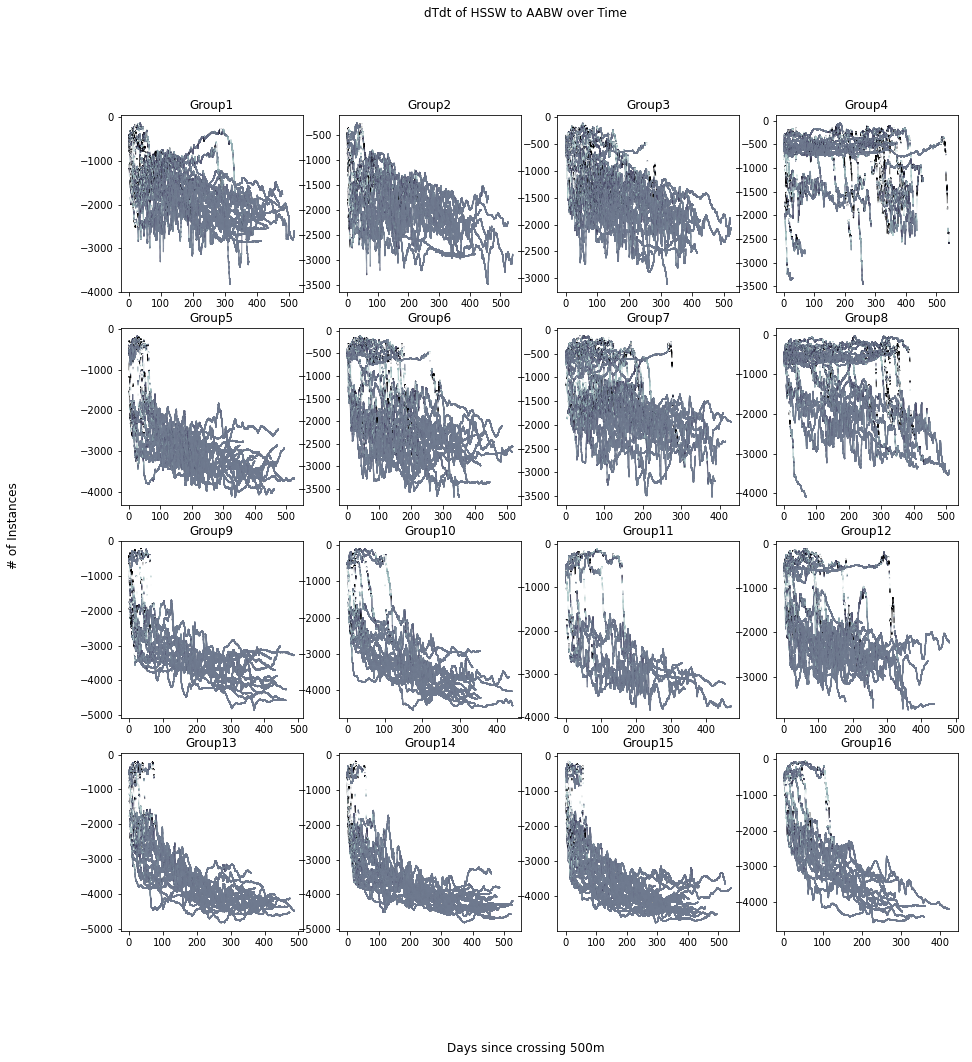

In [70]:
# plot particles with y=depth, x=time, color=temp
fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=5.0)

x_vals = [x_new0,x_new1,x_new2,x_new3,x_new4,x_new5,x_new6,x_new7,x_new8,x_new9,x_new10,x_new11,x_new12,x_new13,x_new14,x_new15]
d_vals = [depth_new0,depth_new1,depth_new2,depth_new3,depth_new4,depth_new5,depth_new6,depth_new7,depth_new8,depth_new9,depth_new10,depth_new11,depth_new12,depth_new13,depth_new14,depth_new15]
c_vals = [dTdt0,dTdt1,dTdt2,dTdt3,dTdt4,dTdt5,dTdt6,dTdt7,dTdt8,dTdt9,dTdt10,dTdt11,dTdt12,dTdt13,dTdt14,dTdt15]
i = 1

fig.suptitle("dTdt of HSSW to AABW over Time")
fig.supxlabel('Days since crossing 500m')
fig.supylabel('# of Instances')

for x,d,c in zip(x_vals,d_vals,c_vals):
    ax = fig.add_subplot(4, 4, i)
    plt.scatter(x,d,marker=".",s=0.05,c=c,vmin=-0.1,vmax=0.1)
    plt.title("Group"+str(i))
    i += 1
plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_107/4x4dTdt_over_time.png", dpi=300)

In [ ]:
temp0.shape

In [ ]:
# plot particles with y=depth, x=time, color=temp
fig = plt.figure(figsize=(15,8))
fig.tight_layout(pad=5.0)
plt.suptitle("dTdt of HSSW to AABW over Time")
ax = fig.add_subplot(2, 2, 1)
plt.scatter(x_new0,depth_new0,marker=".",s=0.05,c=dTdt0,vmin=-0.025,vmax=0.1)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group I")
plt.ylabel('Depth')

ax = fig.add_subplot(2, 2, 2)
plt.scatter(x_new1,depth_new1,marker=".",s=0.05,c=dTdt1,vmin=-0.025,vmax=0.1)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group II")
plt.ylabel('Depth')

ax = fig.add_subplot(2, 2, 3)
plt.scatter(x_new2,depth_new2,marker=".",s=0.05,c=dTdt2,vmin=-0.025,vmax=0.1)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group III")
plt.xlabel('Time (days since start)')
plt.ylabel('Depth')

ax = fig.add_subplot(2, 2, 4)
plt.scatter(x_new3,depth_new3,marker=".",s=0.05,c=dTdt3,vmin=-0.025,vmax=0.1)
cbar = plt.colorbar()
cbar.set_label('Temperature', rotation=270)
plt.title("Group IV")
plt.xlabel('Time (days since start)')
plt.ylabel('Depth')

#plt.show()
plt.savefig("/scratch/project_2000789/muramarg/SOM/meeting_107/dTdt_over_time.png", dpi=300)

### Create a density and residence time map of just the AABW

In [ ]:
alist = [line.rstrip() for line in open('aabw_idxs.txt')]
aabw_idx = np.array([])
for line in alist:
    thisline = line.split()
    for i in thisline:
        aabw_idx = np.append(aabw_idx,int(i))
aabw_idx = aabw_idx.astype(int)

In [ ]:
import time

In [ ]:
x = (ds.variables['Xgrid'].values[:,aabw_idx])
y = (ds.variables['Ygrid'].values[:,aabw_idx])
print(x.shape)
#depth = (ds.variables['depth'][-1].values)

# divide the normal grid by 10
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]
print(xbins.shape,ybins.shape)

# index of bins the particles ending in
x_new = np.digitize(x,xbins)
y_new = np.digitize(y,ybins)

print(x_new)

m2 = []
for i in range(len(xbins)):
    newl = []
    for j in range(len(ybins)):
        newl.append([])
        
    m2.append(newl)
    
# each bin has an average or total time that any one particle spends in it

# for each column\
start_time = time.time()
for i in range(x_new.shape[1]):
#for i in range(1000):
    if i % 1000 == 0:
        print(i,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # get the x and y column values
    thisx = x_new[:,i]
    thisy = y_new[:,i]

    # make a stack of the x and y columns
    pts = np.vstack((thisx,thisy))
    pts = pts.T

    # normalize to the total number of particles
    counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
    counts.pop()
    
    # add each count to a list in the mesh
    for ii in counts[:-1]:
        iind = ii[0][0]
        jind = ii[0][1]
        
        # create the mesh without the scaling by time
        myval = (ii[1]*900)/86400 # current sum of the column totals

        # see if the current number of the mesh is zero, if it is, add to list
        #print(m2[iind][jind])
        
        m2[int(iind)][int(jind)].append(myval)
#print(m2)

In [ ]:
# AVERAGE MESH
mesh = np.zeros((len(xbins),len(ybins)))

# create the mesh based on averages of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = sum(m2[ii][jj])/len(m2[ii][jj])
            if avg<200:
                mesh[ii][jj] = avg
            else:
                print(avg)

# MAX MESH
mesh_max = np.zeros((len(xbins),len(ybins)))

# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = max(m2[ii][jj])
            #print(avg)
            mesh_max[ii][jj] = avg
            #else:
            #    print(avg)
# MIN MESH
mesh_min = np.zeros((len(xbins),len(ybins)))

# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = min(m2[ii][jj])
            if avg<200:
                mesh_min[ii][jj] = avg
            #else:
            #    print(avg)

# STDEV MESH
mesh_std = np.zeros((len(xbins),len(ybins)))

# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = np.std(m2[ii][jj])
            #if avg<200:
            mesh_std[ii][jj] = avg
            
[Xbins, Ybins] = np.meshgrid(ybins,xbins)
print(Xbins.shape)

In [ ]:
# write the mesh to a text file
# # transform the Ybins and Xbins into lat/long points
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values
print(lat_values.shape)
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

In [ ]:
# average values
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh[300:,250:],transform=ccrs.PlateCarree(),zorder=2,vmax=50)
plt.colorbar()
plt.title("Average Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

# maximum values
ax = fig.add_subplot(2, 2, 2, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh_max[300:,250:],transform=ccrs.PlateCarree(),zorder=2,vmax=200)
plt.colorbar()
plt.title("Maximum Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

# minimum values
ax = fig.add_subplot(2, 2, 3, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh_min[300:,250:],transform=ccrs.PlateCarree(),zorder=2)
plt.colorbar()
plt.title("Minimum Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

# standard deviation
ax = fig.add_subplot(2, 2, 4, projection=proj)
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
xlimit = np.arange(350,500,1)
ylimit = np.arange(450,630,1)
plt.pcolormesh(long[300:,250:],lat[300:,250:],mesh_std[300:,250:],transform=ccrs.PlateCarree(),zorder=2,vmax=40)
plt.colorbar()
plt.title("Standard Deviation of Time")
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)

plt.savefig('/scratch/project_2000789/muramarg/SOM/meeting_107/aabw_restime.png')



#myds = ds1.temp[xlimit,ylimit]
#ds1.h.isel(xi_rho=slice(350, 630),eta_rho=slice(300,630)).plot(x="lon_rho", y="lat_rho",transform=ccrs.PlateCarree())